In [1]:
#I want to look at claims data for any year and measure ID. 
# I want to sum the values of specific columns for that measure ID and year, 
# and then calculate the total system benefit per net energy savings in MMBTU.

In [2]:
# Select Claims Year & Measure ID ,   first 7 digits
year = 2024
MeasureID = "SWWH028" 

In [3]:
import pandas as pd
import fastparquetfrom pathlib import Path
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from jinja2 import Template 
 

In [4]:
from cedars__download import fetch_cedars_claims
local_path = fetch_cedars_claims(year)
print(local_path)

✔ Cached file found — skipping download:
    C:\Users\mmh\Documents\GitHub\getdata\cache\Get_Claims2024.parquet
C:\Users\mmh\Documents\GitHub\getdata\cache\Get_Claims2024.parquet


In [5]:
# make claims downloaded local path into a dataframe; ensure the file exists first
if not local_path.exists():
    raise FileNotFoundError(f"No Parquet file for {year} at {local_path}")
# read it
claims_data= pd.read_parquet(local_path, engine="fastparquet")

In [6]:
mask = claims_data["Measure ID"].str.startswith(MeasureID, na=False)
claims_data_subset_meas = claims_data[mask].copy()

In [7]:
column_list = [
    "Annual Gross kW", "Annual Gross kWh","Annual Gross Therm","Total System Benefit"]

def sum_of_col_mult(claims_data_subset_meas, column_list):
    """
    Returns the sum of multiple specified columns in a DataFrame.
    """
    output = []
    for column in column_list:
        if column not in claims_data_subset_meas.columns:
            raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
        output.append(claims_data_subset_meas[column].sum())
    return output
sums = sum_of_col_mult(claims_data_subset_meas, ["Annual Gross kW", "Annual Gross kWh","Annual Gross Therm","Total System Benefit"]) # this is summing all measures, not just the HPWH_FS_Claims

sums = pd.DataFrame([sums], columns=column_list)
sums.index = ["Total"]
sums = sums.apply(pd.to_numeric, errors='coerce')  # Ensure all data is numeric
sums = sums.fillna(0)  # Replace NaN with 0
sums = sums.astype(int)  # Convert to integer type for better readability   
print(sums)


       Annual Gross kW  Annual Gross kWh  Annual Gross Therm  \
Total                0         -75484494             9899908   

       Total System Benefit  
Total              79547623  


In [8]:
kwh_total = sums['Annual Gross kWh'].values[0]
therm_total = sums['Annual Gross Therm'].values[0]

#calculate Total Energy Savings (BTU)
#convert kWh to MMBTU
MMBTU_Electric = kwh_total* 0.00341214 # 1 kWh = 0.00341214 MMBTU
print("MMBTU Electric:")
print(f"{MMBTU_Electric:,.0f}")

#convert Therm to MMBTU
MMBTU_Gas = therm_total * 0.1  # 1 Therm = 0.1 MMBTU
print("MMBTU Gas:")
print(f"{MMBTU_Gas:,.0f}")   

#Net MMBTU Savings
MMBTU_Net = MMBTU_Electric + MMBTU_Gas
print("Net BTU Savings:")    
print(f"{MMBTU_Net:,.0f}")    

MMBTU Electric:
-257,564
MMBTU Gas:
989,991
Net BTU Savings:
732,427


In [9]:
#dataframe BTUs
x = abs(MMBTU_Electric)  
y = abs(MMBTU_Gas)

MMBTU_df = pd.DataFrame(
    {'Technology Type': ['Electric', 'Gas'],
     'MMBTU Use': [abs(x), abs(y)]}
)
print(MMBTU_df)

  Technology Type      MMBTU Use
0        Electric  257563.661357
1             Gas  989990.800000


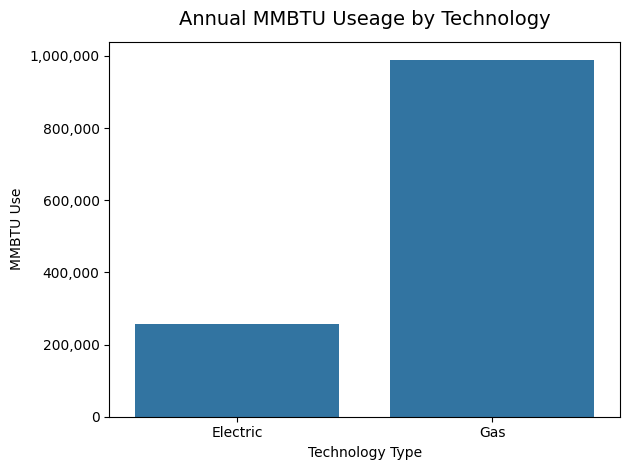

The selected year in this figure is 2024.


In [10]:

# Plotting the MMBTU Impact
MMBTU_Chart = sns.barplot(x='Technology Type', y='MMBTU Use', data=MMBTU_df)
MMBTU_Chart.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
MMBTU_Chart.set_title('Annual MMBTU Useage by Technology', fontsize=14, pad=12)
plt.tight_layout()
plt.show()
print(f"The selected year in this figure is {year}.")

In [11]:
#calculate Rates for CE metrics to compare FS to other measures and to costs
TSB = sums['Total System Benefit'].values[0]
Rate = TSB // MMBTU_Net  # Total System Benefit divided by Net MMBTU Savings
print("TSB per Net Energy Savings ($/MMBTU):") 
print(f"${Rate:,.0f}")  

TSB per Net Energy Savings ($/MMBTU):
$108
